OData API

https://oda.ft.dk/Home/OdataQuery

https://www.odata.org/

https://www.ft.dk/-/media/sites/ft/pdf/dokumenter/aabne-data/oda-browser_brugervejledning.ashx

https://www.odata.org/documentation/odata-version-3-0/url-conventions/

https://www.odata.org/documentation/odata-version-3-0/odata-version-3-0-core-protocol/

Source root Link: "https://oda.ft.dk/api/"

ftp://oda.ft.dk/ODAXML/Referat/samling/


In [18]:
pip install jupyter-kite

Note: you may need to restart the kernel to use updated packages.


## Folketinget data

The data related to the meetings in Folketinget is collected following the guide on Folketinget's homepage:
https://www.ft.dk/-/media/sites/ft/pdf/dokumenter/aabne-data/oda-browser_brugervejledning.ashx.
Transcripts from all meetings going back to 2009 are available for download in xml format using a login described in the guide and some specific ftp software. Because it is interesting to compare topics from Twitter with topics in Folketinget, only the transcripts from the same period as the tweets are used for further analysis. 71% of the available tweets are posted in 2018 and after.

The years in Folketinget do not follow the calender year, as they start and end the first Tuesday of October. So, the meetings from 2017 are actually from October 2017 to October 2018. The data from 2017 are kept for the purpose of having slightly more data and because it is assumed that topics vary little enought for it to still be relevant.

In total 395 meeting stranscripts amounting to 218Mb of data has been downloaded and parsed for analysis.

It is not stated how the transcripts are made, however, they are proofread before publication. 


In [39]:
import pickle
import tweepy #pip install tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np
import statistics as stat

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #legends
from matplotlib.lines import Line2D #circles as legends

import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')

import math
from PIL import Image

#pip install --upgrade networkx
#pip install python-louvain
#pip install community best_partition
#pip install community
import community



# conda install -c conda-forge wordcloud
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# conda install -c conda-forge fa2
from fa2 import ForceAtlas2

import requests
import urllib.request
import os
import io
import json

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import lxml #pip install bs4 lxml

import xml.etree.ElementTree as et 
from xml.dom import minidom
import dateutil
import datetime as dt
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *

from afinn import Afinn #pip install afinn

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
path = os.getcwd()+'/samling/'
path

'/Users/frederikkromannhansen/Documents/GitHub/politiker/samling/'

# Parsing XML

Vi kan slette alle <Char>, $<Linea>$, $<Exitus>$ og tags af denne art $<tag />$. Det er tomme tags, som fucker med systemet. Så er al den relevante data i $<Tale>$ uden forstyrrende elementer. Der skal tilføjes et mellemrum i stedet for char

In [3]:
for subdir, dir, files in os.walk(path):
    for file in files:
        filepath = subdir+'/' + file
        if filepath.endswith(".xml"):
            xmlTree = et.parse(filepath)
            
elemList = []

for elem in xmlTree.iter():
    elemList.append(elem.tag)

# Just printing out the result
from collections import Counter
Counter(elemList)

Counter({'Dokument': 1,
         'MetaMeeting': 1,
         'ParliamentarySession': 1,
         'ParliamentaryGroup': 1,
         'MeetingNumber': 1,
         'DateOfSitting': 1,
         'Location': 1,
         'EdixiDocLocation': 1,
         'AudioFileFolder': 1,
         'TitelGruppe': 1,
         'Titel': 1,
         'Linea': 126,
         'Char': 138,
         'UnderTitel': 1,
         'DagsordenPlan': 1,
         'Rubrica': 10,
         'PunktTekst': 8,
         'Exitus': 72,
         'DagsordenPunkt': 5,
         'MetaFTAgendaItem': 5,
         'ItemNo': 5,
         'FTCase': 5,
         'FTCaseNumber': 5,
         'FTCaseType': 5,
         'FTCaseStage': 5,
         'ShortTitle': 5,
         'Aktivitet': 10,
         'Tale': 12,
         'Taler': 12,
         'MetaSpeakerMP': 12,
         'OratorFirstName': 12,
         'OratorLastName': 12,
         'GroupNameShort': 12,
         'OratorRole': 12,
         'TalerTitel': 12,
         'TaleSegment': 12,
         'MetaSpeechSegme

In [4]:
starttid_vec = []
sluttid_vec=[]
navn_vec = []
efternavn_vec = []
tekst_vec = []
parti_vec = []
rolle_vec = []
meetingID_vec = []


# Go through all the folders and files containing transcripts
for subdir, dir, files in os.walk(path):
    for file in files:
        filepath = subdir+'/' + file
        if (filepath.endswith(".xml")) and not (filepath.endswith("clean.xml")):
            tree = et.parse(filepath)
            root = tree.getroot() 

            for meeting in root.iter('MeetingNumber'):
                meetingID = meeting.text
            # Do this if the speaker has an associated party, i.e. not a minister or the chairman
            for speech in root.iter('Tale'):

                tags=[node.tag for node in speech.iter()]
                if('TekstGruppe' in tags):
                    if('GroupNameShort' in tags):
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                            elif(node.tag=='GroupNameShort'):
                                parti_vec.append(node.text)
                                
                                meetingID_vec.append(meetingID)


                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()

                    # Do this if the speaker is either a minister or the chairman
                    else:
                        parti_vec.append('Ukendt')
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                                
                                meetingID_vec.append(meetingID)

                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()
                    


# Add everything to a dictionary and transform it into a Pandas dataframe
dictionary= {'MeetingID':meetingID_vec, 'StartDateTime':starttid_vec,'OratorFirstName':navn_vec,'OratorLastName':efternavn_vec,
                 'GroupNameShort':parti_vec,'OratorRole':rolle_vec ,'TekstGruppe':tekst_vec} # 'EndDateTime':sluttid_vec,
df = pd.DataFrame(dictionary)

print('In total, there are {} lines of text in the meetings.'.format(len(df)))
#df.to_csv(path[0:26]+'csv')

In total, there are 151571 lines of text in the meetings.


In [5]:
### Cleaning the data ###

### Dropping values from OratorRole ###
# The chariman (formand) does not add value to the context as he or she only moderates the debate
# by passing on the word from person to person.
# Also some meta data is contained regarding when the meeting ended (MødeSlut). This is also irrelevant.
df=df[df['OratorRole']!='formand']
df=df[df['OratorRole']!='MødeSlut']
df['OratorRole'].dropna(axis=0,inplace=True)


### Dropping values from GroupNameShort, i.e. party ###
df=df[df['GroupNameShort']!='UFG']
df=df[df['GroupNameShort']!='Pause']


### Feature engineering new fields and removing redundant fields ### 
# Generating a column of the full name of the speakers
df['FullName'] = df['OratorFirstName']+' '+df['OratorLastName']
df.drop(['OratorFirstName','OratorLastName'],axis='columns', inplace=True)
df=df[df['FullName'].notnull()]


### Resetting the index ###
df.reset_index(drop=True,inplace=True)


### Changing data types ###
# Making start time into datetime64 format
df['StartDateTime'] = df['StartDateTime'].apply(lambda x: dateutil.parser.parse(x))
df['MeetingID']=df['MeetingID'].apply(lambda x: int(x))

#df['ItemNo']=df['ItemNo'].apply(lambda x: int(x))

print('After cleaning, there are {} lines of text in the meetings.'.format(len(df)))

After cleaning, there are 71779 lines of text in the meetings.


So only 47% of the data remains after removing irrelevant speech

In [6]:
df.head()

,MeetingID,StartDateTime,GroupNameShort,OratorRole,TekstGruppe,FullName
0,66,2019-02-27 13:01:45,DF,medlem,Spørgsmålet lyder: Vil regeringen stå fast på...,Christian Langballe
1,66,2019-02-27 13:02:06,None,minister,Tak for det. Og tak for spørgsmålet. Fremmedk...,Søren Pape Poulsen
2,66,2019-02-27 13:03:40,DF,medlem,Det står tilbage at få besvaret nogle ting i ...,Christian Langballe
3,66,2019-02-27 13:04:55,None,minister,"Tak. Jeg skal prøve, så godt jeg kan – det va...",Søren Pape Poulsen
4,66,2019-02-27 13:05:49,DF,medlem,"Altså, jeg synes jo, at de her burkabrude, so...",Christian Langballe


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71779 entries, 0 to 71778
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   MeetingID       71779 non-null  int64         
 1   StartDateTime   71779 non-null  datetime64[ns]
 2   GroupNameShort  58736 non-null  object        
 3   OratorRole      71779 non-null  object        
 4   TekstGruppe     71779 non-null  object        
 5   FullName        71779 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


## Topics



W = Topics og tilhørende vægte. Den her linje har det her topic
H = Ord og hvor meget de hver passer i hvert topic. Det her ord er så meget topic 1 og så meget topic 2

[Navn, Tekst, 

## Sentiment

Since the only language spoken in Folketinget is Danish, the sentiment analyser is configured for Danish.

In [8]:
afinn = Afinn(language='da', emoticons=True)

In [9]:
df['Sentiment'] = df['TekstGruppe'].apply(lambda x: afinn.score(x))

In [10]:
df.head()

,MeetingID,StartDateTime,GroupNameShort,OratorRole,TekstGruppe,FullName,Sentiment
0,66,2019-02-27 13:01:45,DF,medlem,Spørgsmålet lyder: Vil regeringen stå fast på...,Christian Langballe,-1.0
1,66,2019-02-27 13:02:06,None,minister,Tak for det. Og tak for spørgsmålet. Fremmedk...,Søren Pape Poulsen,13.0
2,66,2019-02-27 13:03:40,DF,medlem,Det står tilbage at få besvaret nogle ting i ...,Christian Langballe,1.0
3,66,2019-02-27 13:04:55,None,minister,"Tak. Jeg skal prøve, så godt jeg kan – det va...",Søren Pape Poulsen,4.0
4,66,2019-02-27 13:05:49,DF,medlem,"Altså, jeg synes jo, at de her burkabrude, so...",Christian Langballe,-2.0


#### Meetings text statistics (FREDERIK)

Speech in Folketinget is much more formal than it is on Twitter. Therefore, it is no surprise that the average sentiment for both parties and individual politicians are all positive (except for Henrik Sass Larsen). They often start their speech by being appreciative towards the one posing the question as well as the moderator for receiving the word. Also, they often say that they understand the cause of the question or the like, which adds to a positive sentiment score as well. On the other hand, they primarily discuss disagreements on current issues, contributing to the negative side.

Below is a histogram of the sentiments of each speech. It can be seen that 75% of speeches are positive and the rest are either neutral or negative. Given that most speeches start with a few "thank you"s, a neutral sentiment probably contains a negative message.

In [11]:
def custom_histogram(list_of_values,title_name,x_label,y_label):
    
    #Sturges rule for number of bins
    n_bin=math.ceil(math.log2(len(list_of_values)))+1
    
    hist,bin_edges=np.histogram(list_of_values,bins=n_bin)

    rightboundary=bin_edges[1:]
    leftboundary=bin_edges[:-1]
    newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
    newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
    for i in range(len(rightboundary)):
        newlist_in.append(leftboundary[i])
        newvalues_in.append(hist[i])
        newlist_in.append(rightboundary[i])
        newvalues_in.append(hist[i]) 
    points_in=zip(newlist_in,newvalues_in)


    plt.figure(figsize=(8,8))
    plt.plot(newlist_in,newvalues_in,color='#0504aa')
    for pt in points_in:
        plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )

    plt.title(title_name,fontsize=18)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.show()

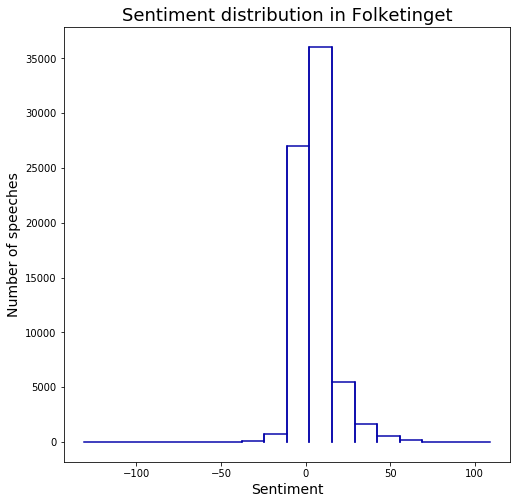

In [12]:
custom_histogram(df['Sentiment'],'Sentiment distribution in Folketinget','Sentiment','Number of speeches')

In [13]:
print('At least',round(len(df[df['Sentiment'] <= 0])/len(df)*100,1),'% of speeches convey a negative message.')

At least 24.9 % of speeches convey a negative message.


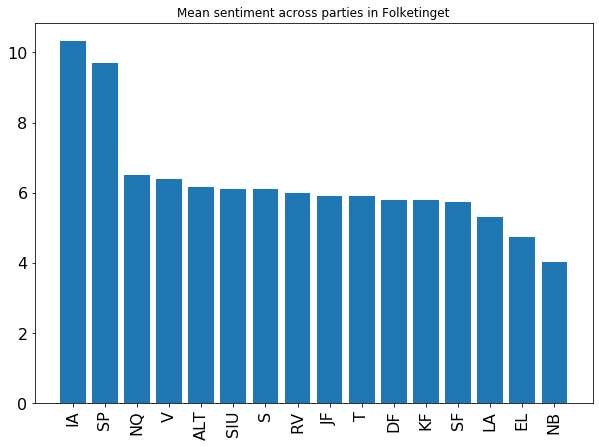

In [14]:
avg_sentiment_party = df.groupby('GroupNameShort').agg({'Sentiment': (lambda column: stat.mean(column))}).sort_values('Sentiment',ascending=False).reset_index()

fig = plt.subplots(figsize=(10,7))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_sentiment_party['GroupNameShort'],avg_sentiment_party['Sentiment'])
plt.title("Mean sentiment across parties in Folketinget")
plt.show()

In [15]:
df.groupby('FullName').agg({"TekstGruppe": (lambda column: "".join(column)), 'Sentiment': (lambda column: stat.mean(column))}).sort_values('Sentiment').head()

,TekstGruppe,Sentiment
FullName,,
Henrik Sass Larsen,"Tak for det. Se, Folketinget godkender jo hve...",-1.250000
Preben Bang Henriksen,Tak. Advokater har en særlig rolle i det dans...,0.597561
Jesper Kiel,Jeg vil gerne stille et spørgsmål til hr. Ren...,1.214286
Lars Aslan Rasmussen,Tak. Når nu det iranske præstestyre fortsætte...,1.438776
Johanne Schmidt-Nielsen,Tak for det. Dansk Folkeparti foreslår at ind...,1.777778


To compare the sentiments and topics of Folketinget with Twitter, only the politicians from Folketinget who are also on twitter will be analyzed going forward. So, first the dataset from Folketinget are joined with the Twitter names in an inner join, to filter out the politicians without Twitter that has not been analyzed in previous sections of this project. This leaves 46,207 speeches equivalet to 64.4% of the previously analyzed data. Unfortunately, this also means that 500 Twitter accounts are not included in this analysis including profiles such as Magrethe Vestager's, since she is not in Folketinget.

In [16]:
data=pd.read_csv("danish_politkere_twitter.csv")
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [17]:
data.head()

,Names,Twittername
0,Margrethe Vestager,vestager
1,Lars Løkke Rasmussen,larsloekke
2,Morten Østergaard,oestergaard
3,Pernille Skipper,PSkipperEL
4,Ida Auken,IdaAuken


In [24]:
data.rename(columns = {'Names':'FullName'}, inplace = True)
df2 = pd.merge(df, data, on='FullName', how='inner')
#df2 = df2[df2['Twittername'].notnull()]
#df2.reset_index(drop=True,inplace=True)
#df2['MeetingID']=df2['MeetingID'].apply(lambda x: int(x))

In [25]:
df2.head()

,MeetingID,StartDateTime,GroupNameShort,OratorRole,TekstGruppe,FullName,Sentiment,Twittername
0,66,2019-02-27 13:02:06,None,minister,Tak for det. Og tak for spørgsmålet. Fremmedk...,Søren Pape Poulsen,13.0,SorenPape
1,66,2019-02-27 13:04:55,None,minister,"Tak. Jeg skal prøve, så godt jeg kan – det va...",Søren Pape Poulsen,4.0,SorenPape
2,66,2019-02-27 13:06:41,None,minister,"Det forstår jeg også godt, og det er jo derfo...",Søren Pape Poulsen,6.0,SorenPape
3,66,2019-02-27 13:08:23,None,minister,"Jamen jeg gentager gerne, at jeg tror, at jeg...",Søren Pape Poulsen,4.0,SorenPape
4,66,2019-02-27 13:09:30,None,minister,Tak for spørgsmålet. Og nu fra det forrige ti...,Søren Pape Poulsen,4.0,SorenPape


In [26]:
print('Removing politicians without Twitter leaves',round(len(df2)/len(df)*100,1),'% of data remaining.')

Removing politicians without Twitter leaves 64.4 % of data remaining.


In [27]:
print('Unfortunately, only ', len(set(df2['Twittername'])), ' out of ',len(set(data['Twittername'])),' politicians are analyzed going forward.')

Unfortunately, only  151  out of  651  politicians are analyzed going forward.


In [28]:
df2.groupby('FullName').agg({"TekstGruppe": (lambda x: "".join(x)), 'Sentiment': (lambda x: stat.mean(x))}).sort_values('Sentiment')

,TekstGruppe,Sentiment
FullName,,
Jesper Kiel,Jeg vil gerne stille et spørgsmål til hr. Ren...,1.214286
Pernille Vermund,Tak for ordet. I Nye Borgerlige synes vi best...,1.830645
Rasmus Stoklund,(Talen er under udarbejdelse) (Talen er under...,2.167123
Nick Hækkerup,"NATO forfølger en åben dør-politik, således a...",2.181818
Rosa Lund,Tak. Jeg vil gerne fortsætte lidt i samme spo...,2.639731
...,...,...
Hans Christian Schmidt,"Lovforslaget, som vi behandler i dag, skal si...",11.420000
Daniel Toft Jakobsen,Tak for det. De danske folkebiblioteker er en...,11.634146
Morten Marinus,Tak for det. Og tak til ordføreren. Vi er jo ...,11.823529


In [29]:
folketinget_dict_text={"Dummy":{}}

n_count=0
n_total=len(set(df2['Twittername']))

for p in set(df2['Twittername']):   
    n_count=n_count+1

    # The speaker who we want to get sentences from
    name = p

    try:
        ##Updating dict
        folketinget_dict_text.update({name:{}})

        ###############========== FINDING SPEECHES FOR PERSON=============#####
        for i,sentence in enumerate(df2[df2['Twittername']==name]['TekstGruppe']):

            if i==0:
                folketinget_dict_text[name]=[sentence]
            else:
                folketinget_dict_text[name].append(sentence)
    except:
        print("Error at {}".format(name)) 
        
del folketinget_dict_text["Dummy"]

folketinget_dict_concat = dict()
for pol in list(folketinget_dict_text.keys()):
    folketinget_dict_concat[pol]=' '.join(folketinget_dict_text[pol])

In [31]:
 with open('communities.data', 'rb') as filehandle:
    # store the data as binary data stream
    partition_GCC=pickle.load(filehandle)

In [32]:
from collections import Counter
communities = len(set(partition_GCC.values()))
print(communities,' communities are found in total.')

a = np.array(list(partition_GCC.values()))
b = Counter(a)

#Extracting the number of nodes in each commnuity
community_sizes=[i[1] for i in b.most_common(communities)]

print('The sizes are: ', community_sizes)

16  communities are found in total.
The sizes are:  [77, 51, 49, 47, 46, 43, 42, 40, 37, 33, 29, 25, 16, 11, 6, 3]


In [33]:
with open('tweet_concat_v2.data', 'rb') as filehandle:
    dict_concat = pickle.load(filehandle)  

In [34]:
stopwords_danish = stopwords.words('danish')

In [60]:
Danish_stopwords = open('stopord.txt').read().splitlines() #Link: https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b

In [61]:
STOPWORDS=STOPWORDS.union(stopwords_danish)
STOPWORDS=STOPWORDS.union(['rt','lige','kan','så','ved','spørgsmål','spørgsmålet','hvert','bruge','både','måde'])# RT is some twitter syntax 
STOPWORDS=STOPWORDS.union(Danish_stopwords)

In [62]:
largest_communities=list(set(partition_GCC.values()))

In [64]:
community_text =  dict()
TF_folketinget = dict()

for i in largest_communities:
   
    common_characters = [k for k,v in list(partition_GCC.items()) if v == largest_communities[i]]
    # reset collection of words for each community
    words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(folketinget_dict_concat.keys()):
            if pol in common_characters:
                words += nltk.word_tokenize(folketinget_dict_concat[pol])
    
    # enter all text from community i in a dict
    tokens = [word.lower() for word in words if (word.isalnum() and word.lower() not in STOPWORDS)]
    
    community_text[largest_communities[i]] = tokens

for i in community_text.keys():
    TF_folketinget[i] = FreqDist(community_text[i])

In [65]:
# number of words and text
common_communities=largest_communities
for i in range(len(common_communities)):
    print('Community ', common_communities[i],' has ', len(community_text[common_communities[i]]), ' words')

Community  0  has  193261  words
Community  1  has  87196  words
Community  2  has  35072  words
Community  3  has  193838  words
Community  4  has  97080  words
Community  5  has  294396  words
Community  6  has  621587  words
Community  7  has  288643  words
Community  8  has  227355  words
Community  9  has  348403  words
Community  10  has  127180  words
Community  11  has  33643  words
Community  12  has  97460  words
Community  13  has  58582  words
Community  14  has  131051  words
Community  15  has  42631  words


In [47]:
#inverse document frequency
def IDF_for_word(word, this_com_name, TF_other_community, N):
 
    nt=0
 
    for com in list(TF_other_community.keys()):
        if word in TF_other_community[com] and com != this_com_name:
            nt = nt+1
 
    w_IDF=np.log(N/(nt+1))+1
    return w_IDF

In [48]:
IDF = dict()

for community in TF_folketinget.keys():
    IDF.update({community: {}})
    for word in TF_folketinget[community].keys():
        IDF[community].update({word: IDF_for_word(word, community, TF_folketinget, 7)})

In [49]:
TF_IDF = dict()

for community in TF_folketinget.keys():
    TF_IDF.update({community: {}})
    for word in TF_folketinget[community].keys():
        TF_IDF[community].update({word: TF_folketinget[community][word]*IDF[community][word]})

In [50]:
christiansborg_mask=np.array(Image.open('christiansborg_sil.jpg'))

In [58]:
SWs=set(STOPWORDS)

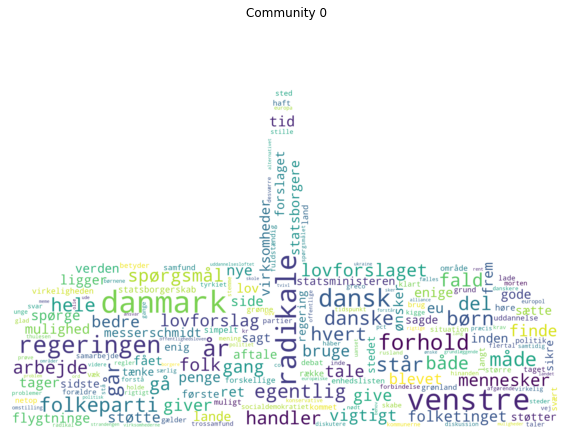

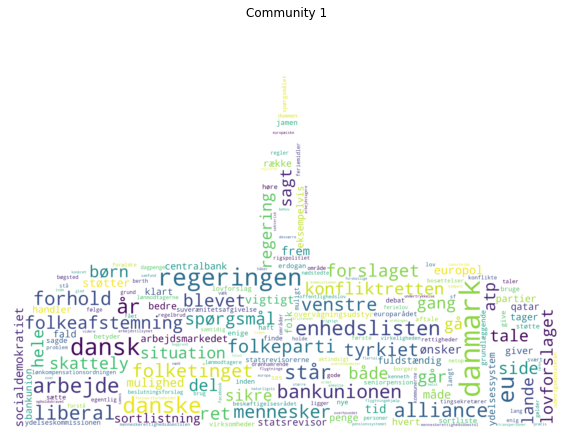

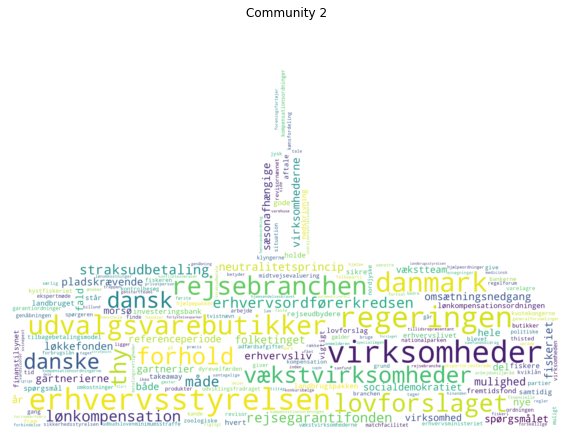

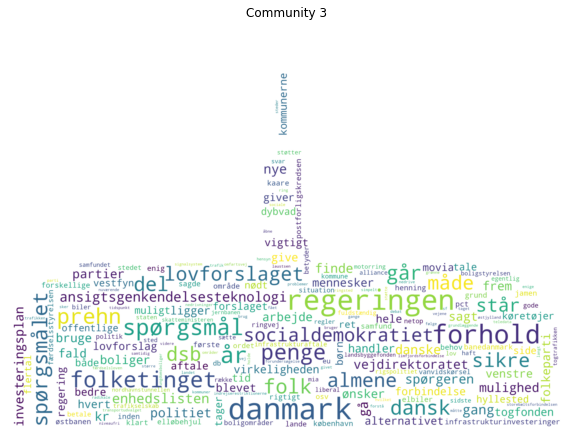

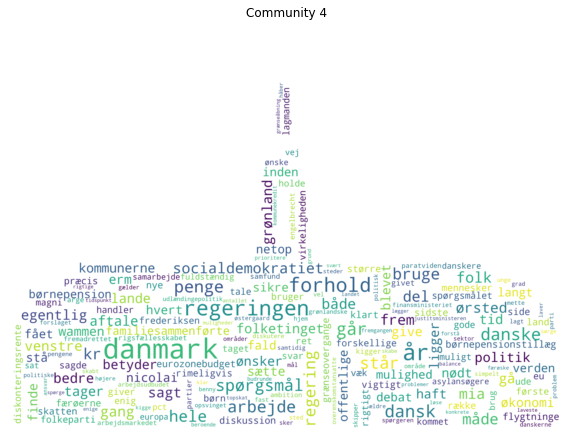

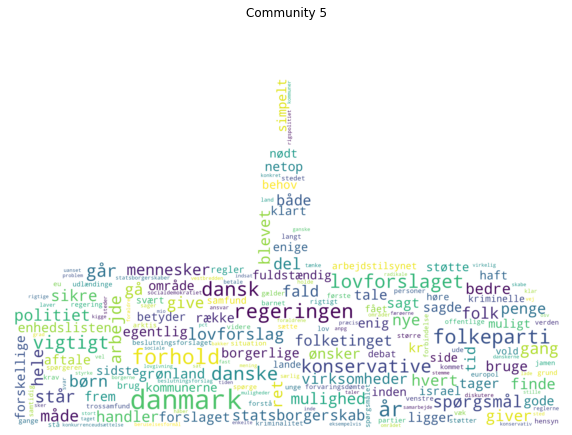

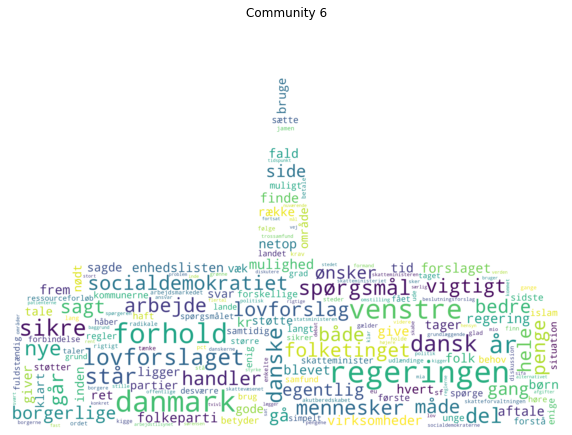

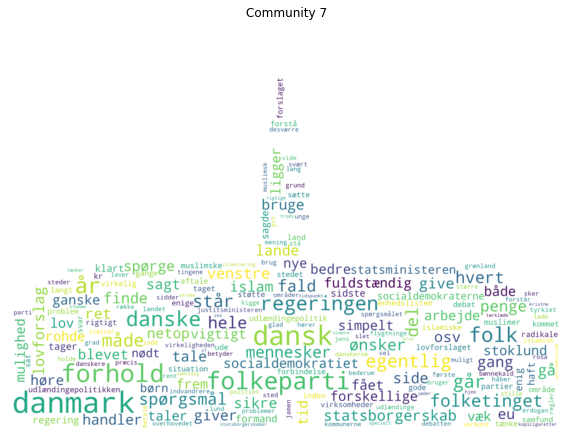

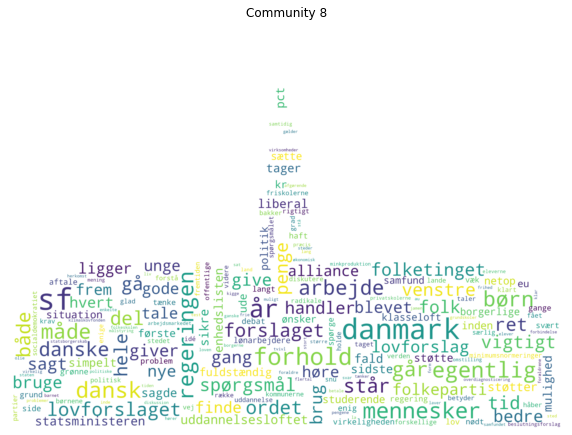

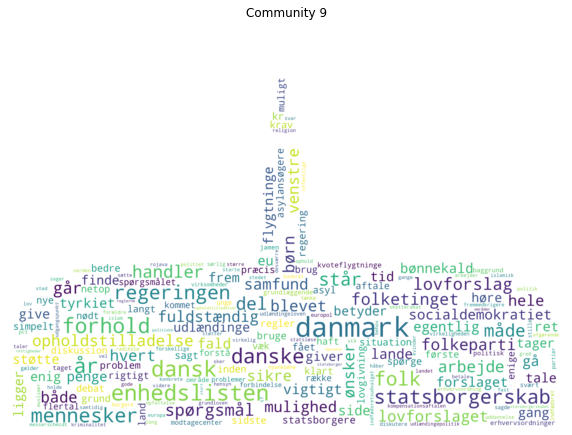

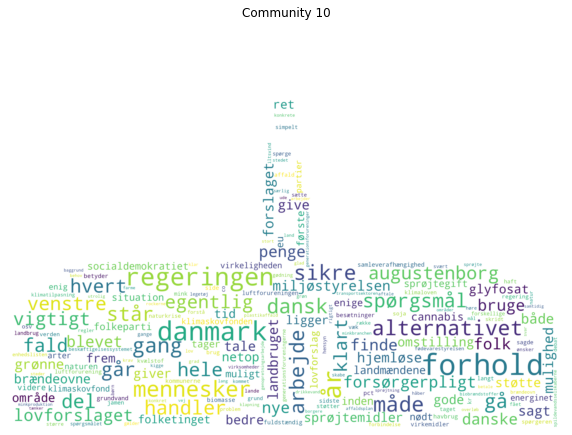

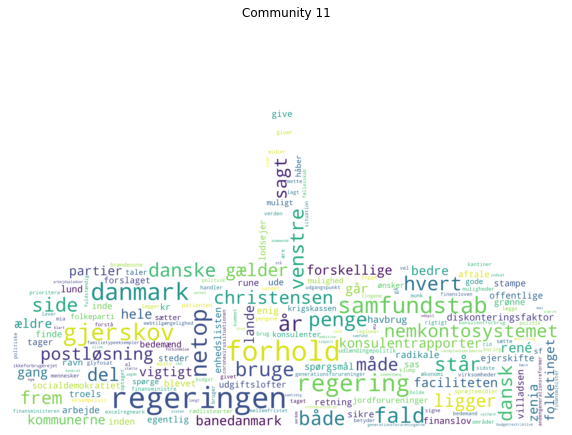

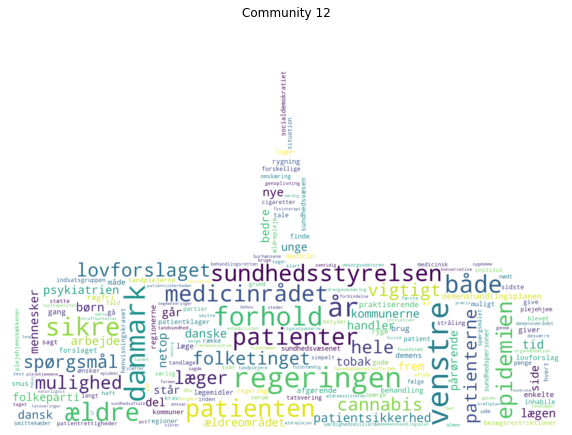

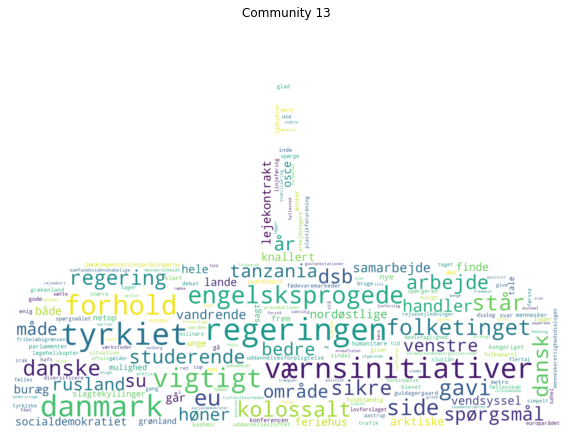

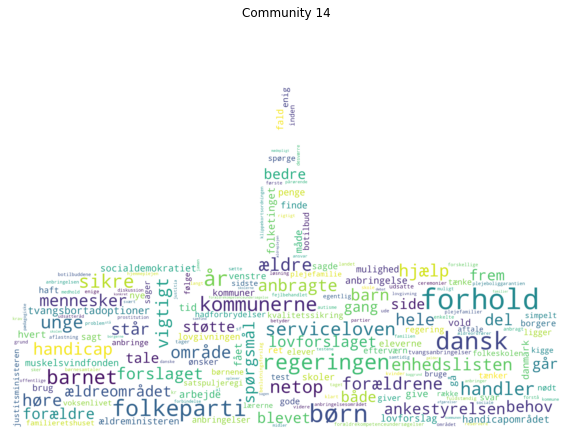

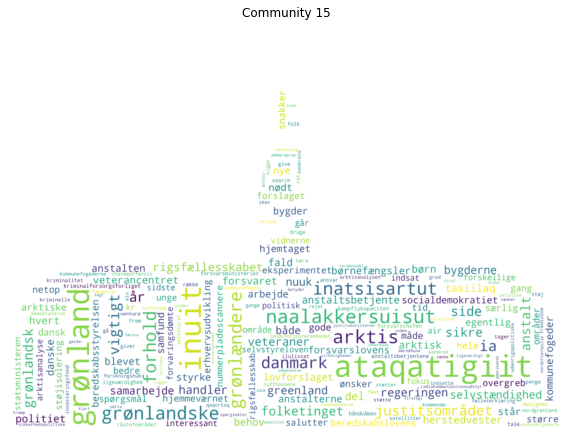

In [59]:
for community in TF_IDF.keys():
    community_WordCloudText = ' '.join([word for word in list(TF_IDF[community].keys()) for i in range(math.ceil(TF_IDF[community][word]))])

    plt.figure(figsize=(10,20))
    community_wordcloud = WordCloud(collocations=False, mask=christiansborg_mask, background_color='white', stopwords=SWs).generate(community_WordCloudText)
    plt.imshow(community_wordcloud, interpolation='bilinear')
    #plt.savefig('christiansborg_com_wordclouds/community'+str(community)+'.png')
    plt.title(label=('Community '+str(community)))
    plt.axis("off")